In [1]:
import os
import s3prl.hub as hub
import torch
import soundfile as sf
import librosa
import pickle

import torchaudio
from torchaudio.models.rnnt import _Predictor
import torchaudio.transforms as transforms
from torchaudio.functional import resample
import torch.nn.functional as F
import time
from sklearn.cluster import KMeans
import IPython.display as display
import numpy as np

from soft_vc_wavlm.acoustic_model.acoustic_model import AcousticModel
from importlib import reload
import soft_vc_wavlm.acoustic_model.acoustic_model
reload(soft_vc_wavlm.acoustic_model.acoustic_model)
import matplotlib.pylab as plt
import faiss
%matplotlib inline

/home/prabhune/miniconda3/envs/speech/lib/python3.8/site-packages/s3prl/upstream/byol_s/byol_a/common.py:20: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("sox_io")
ESPnet is not installed, cannot use espnet_hubert upstream
/home/prabhune/miniconda3/envs/speech/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda:0"

In [12]:
class LogMelSpectrogram(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.melspctrogram = transforms.MelSpectrogram(
            sample_rate=16000,
            n_fft=1024,
            win_length=1024,
            hop_length=160,
            center=False,
            power=1.0,
            norm="slaney",
            onesided=True,
            n_mels=128,
            mel_scale="slaney",
        )

    def forward(self, wav):
        padding = (1024 - 160) // 2
        wav = F.pad(wav, (padding, padding), "reflect")
        mel = self.melspctrogram(wav)
        logmel = torch.log(torch.clamp(mel, min=1e-5))
        return logmel

In [13]:
model_name = "wavlm_large"
wavlm_model = getattr(hub, model_name)()

wavlm_model = wavlm_model.to(device)

/home/prabhune/miniconda3/envs/speech/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [14]:
wav, sr = torchaudio.load("audios/wav/mngu0_s1_1263.wav")
wav = wav.to(device)
print(len(wav[0]))

with torch.no_grad():
    states = wavlm_model(wav)["hidden_states"]

feature = states[9].squeeze(0)

47781


/home/prabhune/miniconda3/envs/speech/lib/python3.8/site-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [15]:
kmeans = pickle.load(open("soft_vc_wavlm/acoustic_model/kmeans_ckpt/kmeans_100_trained.pkl", "rb"))
feature_kmeans = torch.tensor(kmeans.predict(feature.cpu().numpy())).to(device)
print(feature_kmeans.shape)
feature_kmeans = torch.tensor(feature_kmeans).to(device)
length = 2 * feature_kmeans.shape[0]

torch.Size([149])


/tmp/ipykernel_346444/81038070.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature_kmeans = torch.tensor(feature_kmeans).to(device)


In [21]:
melspectrogram = LogMelSpectrogram()
#wav, sr = torchaudio.load("../LJSpeech-1.1/wavs/LJ001-0001.wav")
wav, sr = torchaudio.load("audios/wav/mngu0_s1_0001.wav")
wav = resample(wav, sr, 16000)
mel = melspectrogram(wav.unsqueeze(0)).squeeze(0).transpose(2, 1).to(device)[:, :length, :]

In [22]:
state_dict = torch.load("soft_vc_wavlm/acoustic_model/ckpts/model-best.pt")["acoustic-model"]
changed_state_dict = {}
for key in state_dict.keys():
    changed_state_dict[key[7:]] = state_dict[key]
trained_acoustic = AcousticModel(discrete=True).to(device)
trained_acoustic.load_state_dict(changed_state_dict)

<All keys matched successfully>

In [23]:
pred_mels = trained_acoustic(feature_kmeans.unsqueeze(0), mel).squeeze(0)
pred_mels = pred_mels.cpu().detach().numpy()
print(pred_mels.shape)

(298, 128)


In [24]:
mel_np = mel.squeeze(0).cpu().detach().numpy()

[Text(0.5, 1.0, 'Ground Truth Mel Spectrogram')]

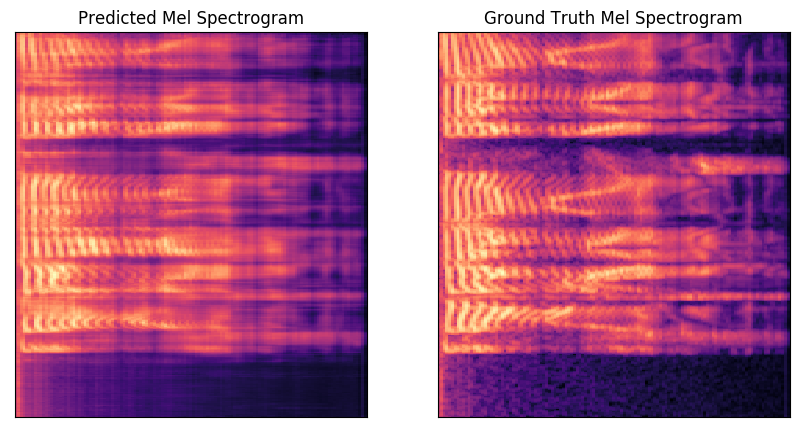

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
librosa.display.specshow(pred_mels, ax=ax[0])
ax[0].set(title="Predicted Mel Spectrogram")

librosa.display.specshow(mel_np, ax=ax[1])
ax[1].set(title="Ground Truth Mel Spectrogram")